In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [2]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [3]:
currency=pd.read_excel('currency_data.xlsx')

## 클리닝

In [4]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [5]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [6]:

df = df[df['미입고 기간'].isnull()]
df = df.dropna(subset=['창고입고'])

In [7]:
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')
currency['기간'] = pd.to_datetime(currency['기간'], errors='coerce')
df['발주'] = pd.to_datetime(df['발주'], errors='coerce')

In [8]:

df['리드타임'] = (df['창고입고'] - df['발주']).dt.days
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

df = df[(df['리드타임'] > 1 ) & (df['리드타임'] < 200)]

In [9]:
df = pd.merge_asof(df.sort_values('창고입고'), 
                   currency.sort_values('기간'), 
                   left_on='창고입고', 
                   right_on='기간', 
                   direction='backward')

In [10]:
def get_exchange_rate(row):
    if row['견적화폐'] == 'USD':
        return row['USD']
    elif row['견적화폐'] == 'JPY':
        return row['JPY']
    elif row['견적화폐'] == 'EUR':
        return row['EUR']
    else:
        return 1  # KRW일 경우 1을 반환

# 3. 새 칼럼 '환율' 추가하여 환율 값 저장
df['환율'] = df.apply(get_exchange_rate, axis=1)

# 4. 빈 환율 값이 있는지 확인
print(df['환율'].isnull().sum())  # 빈 값 개수 확인

# 5. 빈 값 채우기: 가장 가까운 날짜의 환율을 사용
df['환율'].fillna(method='ffill', inplace=True)  # 이전 값으로 채움 (ffill 방식)


3


C:\Users\User\AppData\Local\Temp\ipykernel_11168\3499480130.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['환율'].fillna(method='ffill', inplace=True)  # 이전 값으로 채움 (ffill 방식)
C:\Users\User\AppData\Local\Temp\ipykernel_11168\3499480130.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['환율'].fillna(method='ffill', inplace=True)  # 이전 값으로 채움 (ffill 방식)


In [17]:
print(df.columns)
df['리드타임'] = df['리드타임'].astype(float)

Index(['청구서번호', 'No.', 'Subject', 'Machinery', 'Assembly', '청구품목',
       'Unnamed: 6', 'Part No.1', 'Part No.2', '청구량', '견적', '견적수량', '견적화폐',
       '견적단가', '발주번호', '발주처', '발주', '발주수량', '발주금액', 'D/T', '미입고 기간', '창고입고',
       '창고입고수량', 'Control No.', '입고창고', '창고출고', '창고출고수량', '출고선박', '출고운반선',
       '선박입고', '선박입고수량', '완료 여부', '리드타임', '기간', 'USD', 'JPY', 'EUR', '환율',
       'year', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'season_겨울', 'season_봄', 'season_여름',
       'cleaned_machinery', 'cleaned_assembly', 'cleaned_item',
       'cleaned_supplier'],
      dtype='object')


In [18]:

df = df.drop(columns=['청구서번호', 'No.', 'Subject','Unnamed: 6','Part No.2', '청구량', '견적', '견적수량','Control No.', '입고창고', '창고출고', '창고출고수량', '출고선박', '출고운반선',
       '선박입고', '선박입고수량', '완료 여부','기간', 'USD', 'JPY', 'EUR'])

환율    0
dtype: int64


In [19]:
df.head()

,Machinery,Assembly,청구품목,Part No.1,견적화폐,견적단가,발주번호,발주처,발주,발주수량,...,day_of_week_4,day_of_week_5,day_of_week_6,season_겨울,season_봄,season_여름,cleaned_machinery,cleaned_assembly,cleaned_item,cleaned_supplier
0,MAIN ENGINE,"EXHAUST MANIFOLD, DUAL PIPE PART 328X1136",CLAMP WITH T-BOLT AND NUTS,228X1004-2,KRW,181800.0,SEG-BS-OSP-1901002,유신에이치알(사용금지),2019-01-04,16,...,False,True,False,True,False,False,main engine,"exhaust manifold, dual pipe part 328x1136",clamp with t-bolt and nuts,유신에이치알
1,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,SPRING-PINION,5N-8380,KRW,16220.0,TER-BS-OSP-1901001,HAEIN Coporation_Cheonan(사용금지),2019-01-04,2,...,False,False,True,True,False,False,no.1 generator engine,143-5174 motor gp-air stg,spring-pinion,haein _cheonan
2,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,WASHER-PINION,5N-8425,KRW,21890.0,TER-BS-OSP-1901001,HAEIN Coporation_Cheonan(사용금지),2019-01-04,2,...,False,False,True,True,False,False,no.1 generator engine,143-5174 motor gp-air stg,washer-pinion,haein _cheonan
3,MAIN ENGINE,"EXHAUST MANIFOLD, DUAL PIPE PART 328X1136","END SECTION, EXHAUST MANIFOLD",328X1026,KRW,1177400.0,SEG-BS-OSP-1901005,유신에이치알(사용금지),2019-01-09,2,...,False,False,True,True,False,False,main engine,"exhaust manifold, dual pipe part 328x1136","end section, exhaust manifold",유신에이치알
4,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,SCREW-PINION,5N-8403,KRW,3960.0,TER-BS-OSP-1901001,HAEIN Coporation_Cheonan(사용금지),2019-01-04,2,...,False,False,True,True,False,False,no.1 generator engine,143-5174 motor gp-air stg,screw-pinion,haein _cheonan


### 날짜에서 피쳐 뽑기

> 연도는 숫자형으로 처리(새로운 연도에 대응)
> 나머지는 원핫인코딩

In [14]:
# 월(month), 요일(day of the week) 추출
df['month'] = df['창고입고'].dt.month
df['day_of_week'] = df['창고입고'].dt.dayofweek
df['year'] = df['창고입고'].dt.year

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['season'] = df['창고입고'].apply(get_season)

df = pd.get_dummies(df, columns=['month', 'day_of_week', 'season'], drop_first=True)


In [15]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name



In [16]:

text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

In [20]:
# Machinery별 평균 리드타임 계산
machinery_avg_leadtime = df.groupby('cleaned_machinery')['리드타임'].mean().reset_index()
machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(machinery_avg_leadtime, on='cleaned_machinery', how='left')

In [21]:
# Machinery & Assembly 조합별 평균 리드타임 계산
df['machinery_assembly'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly']
assembly_machinery_avg_leadtime = df.groupby('machinery_assembly')['리드타임'].mean().reset_index()
assembly_machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 Machinery & Assembly 조합의 평균 리드타임 추가
df = df.merge(assembly_machinery_avg_leadtime, on='machinery_assembly', how='left')


In [22]:
# 발주처별 평균 리드타임 계산 (cleaned_supplier 사용)
# supplier_leadtime_avg = df.groupby('cleaned_supplier')['리드타임'].mean().reset_index()
#supplier_leadtime_avg.rename(columns={'리드타임': 'supplier_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 발주처별 평균 리드타임 추가 (cleaned_supplier로 병합)
# df = df.merge(supplier_leadtime_avg, on='cleaned_supplier', how='left')


In [23]:
# 발주처별 + Machinery 조합별 평균 리드타임 계산
supplier_machinery_leadtime = df.groupby(['cleaned_supplier', 'cleaned_machinery'])['리드타임'].mean().reset_index()
supplier_machinery_leadtime.rename(columns={'리드타임': 'supplier_machinery_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 병합
df = df.merge(supplier_machinery_leadtime, on=['cleaned_supplier', 'cleaned_machinery'], how='left')

In [24]:
df[['Machinery','Assembly','리드타임', '발주처', 'machinery_avg_leadtime','machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']].head(20)

,Machinery,Assembly,리드타임,발주처,machinery_avg_leadtime,machinery_assembly_avg_leadtime,supplier_machinery_avg_leadtime
0,MAIN ENGINE,"EXHAUST MANIFOLD, DUAL PIPE PART 328X1136",8.0,유신에이치알(사용금지),87.442457,112.857143,139.569832
1,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,9.0,HAEIN Coporation_Cheonan(사용금지),75.425197,49.120000,72.658173
2,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,9.0,HAEIN Coporation_Cheonan(사용금지),75.425197,49.120000,72.658173
3,MAIN ENGINE,"EXHAUST MANIFOLD, DUAL PIPE PART 328X1136",4.0,유신에이치알(사용금지),87.442457,112.857143,139.569832
4,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,9.0,HAEIN Coporation_Cheonan(사용금지),75.425197,49.120000,72.658173
5,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,9.0,HAEIN Coporation_Cheonan(사용금지),75.425197,49.120000,72.658173
6,NO.1 GENERATOR ENGINE,143-5174 MOTOR GP-AIR STG,9.0,HAEIN Coporation_Cheonan(사용금지),75.425197,49.120000,72.658173
7,BOW ORTZA WINCH,BRAKE GP,10.0,(주)선진엔텍(사용금지),54.102564,51.300000,10.000000
8,No.1 S-BAND RADAR,SN30AF ANTENNA UNIT,15.0,SHINA,30.580645,12.666667,28.230769
9,No.1 S-BAND RADAR,SN30AF ANTENNA UNIT,15.0,SHINA,30.580645,12.666667,28.230769


C:\Users\User\anaconda3\envs\ship\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\ship\Lib\site-packages\IPython\core\pylabtools.py:17

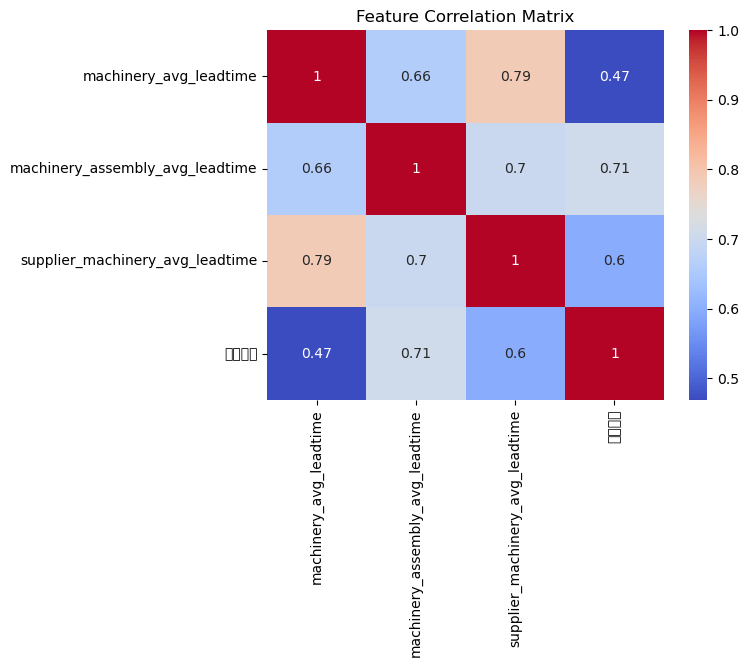

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피처 간 상관관계 계산 및 시각화
correlation_matrix = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 
                         'supplier_machinery_avg_leadtime', '리드타임']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.rcParams['font.family']='Malgun Gothic'
plt.title('Feature Correlation Matrix')
plt.show()

### 데이터 저장용! 실행주의 

In [ ]:
fixed_columns = [
    'cleaned_machinery', 'cleaned_assembly', '청구품목',  'cleaned_supplier', '리드타임',
    'machinery_avg_leadtime', 'machinery_assembly_avg_leadtime',  
    'supplier_avg_leadtime', '견적화폐'
]

# 해당 컬럼들만 선택하여 새로운 데이터프레임 생성
df_fixed = df[fixed_columns]

# 고정 피처들을 CSV로 저장
df_fixed.to_csv('leadtime_features.csv', index=False)

print("고정 피처가 포함된 CSV 파일이 저장되었습니다.")

In [ ]:
past_columns = [
    'Machinery', 'Assembly', '청구품목', 'Part No.1', '견적화폐', '견적단가', '발주처', '발주', '창고입고', '리드타임'
]

# 해당 컬럼들만 선택하여 새로운 데이터프레임 생성
df_past = df[past_columns]

# 고정 피처들을 CSV로 저장
df_past.to_csv('past_leadtime.csv', index=False)

print("과거 리드타임 포함된 CSV 파일이 저장되었습니다.")

### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 word2vec
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

In [27]:
from gensim.models import Word2Vec

# 데이터 전처리 후 토큰화 (문장을 단어 리스트로 변환)
machinery_sentences = [text.split() for text in df['cleaned_machinery']]
assembly_sentences = [text.split() for text in df['cleaned_assembly']]

# 각각의 Word2Vec 모델 학습
word2vec_machinery = Word2Vec(sentences=machinery_sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_assembly = Word2Vec(sentences=assembly_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 각 텍스트에 대한 벡터 평균값 계산 (문장 단위로 벡터를 평균화하여 문장 벡터 생성)
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 각 컬럼별로 벡터화
machinery_vectors = np.array([sentence_vector(sentence, word2vec_machinery) for sentence in machinery_sentences])
assembly_vectors = np.array([sentence_vector(sentence, word2vec_assembly) for sentence in assembly_sentences])

# 결과 확인
print(f"Word2Vec Machinery Shape: {machinery_vectors.shape}")
print(f"Word2Vec Assembly Shape: {assembly_vectors.shape}")


Word2Vec Machinery Shape: (19330, 100)
Word2Vec Assembly Shape: (19330, 100)


In [ ]:
# Word2Vec 모델 저장 (Gensim 방식)
word2vec_machinery.save('word2vec_machinery.model')
word2vec_assembly.save('word2vec_assembly.model')

In [40]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# PolynomialFeatures 인스턴스 생성 (차수는 2로 설정)
poly = PolynomialFeatures(degree=2, include_bias=False)

# 다항식 변환을 적용할 피처들 선택 (환율, 발주수량, 견적단가)
features = df[['환율', '발주수량', '견적단가']].values

# 다항식 변환 적용
poly_features = poly.fit_transform(features)

# 변환된 다항식 특징을 데이터프레임으로 변환
poly_feature_names = poly.get_feature_names_out(['환율', '발주수량', '견적단가'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# 기존 데이터프레임과 결합
df = pd.concat([df, poly_df], axis=1)

print(df.head())  # 결과 확인

               Machinery                                   Assembly  \
0            MAIN ENGINE  EXHAUST MANIFOLD, DUAL PIPE PART 328X1136   
1  NO.1 GENERATOR ENGINE                  143-5174 MOTOR GP-AIR STG   
2  NO.1 GENERATOR ENGINE                  143-5174 MOTOR GP-AIR STG   
3            MAIN ENGINE  EXHAUST MANIFOLD, DUAL PIPE PART 328X1136   
4  NO.1 GENERATOR ENGINE                  143-5174 MOTOR GP-AIR STG   

                            청구품목   Part No.1 견적화폐       견적단가  \
0     CLAMP WITH T-BOLT AND NUTS  228X1004-2  KRW   181800.0   
1                  SPRING-PINION     5N-8380  KRW    16220.0   
2                 WASHER-PINION      5N-8425  KRW    21890.0   
3  END SECTION, EXHAUST MANIFOLD    328X1026  KRW  1177400.0   
4                   SCREW-PINION     5N-8403  KRW     3960.0   

                 발주번호                             발주처         발주 발주수량  ...  \
0  SEG-BS-OSP-1901002                    유신에이치알(사용금지) 2019-01-04   16  ...   
1  TER-BS-OSP-1901001  HAEIN Cop

In [37]:
df['환율_발주수량_상호작용'] = df['환율'] * df['발주수량']


In [38]:
df['환율_발주수량_상호작용'].head()

0    16.0
1     2.0
2     2.0
3     2.0
4     2.0
Name: 환율_발주수량_상호작용, dtype: float64

In [41]:
from sklearn.preprocessing import MinMaxScaler

# 1. 수치형 피처 스케일링
scaler = MinMaxScaler()

# 수치형 피처 (리드타임 관련 피처들) 스케일링
numerical_features = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']+ list(poly_feature_names)].values
scaled_numerical_features = scaler.fit_transform(numerical_features)

print(scaled_numerical_features)


[[6.11301846e-01 5.77380952e-01 7.55878200e-01 ... 1.30102041e-06
  1.11892991e-01 5.51436565e-06]
 [5.22426179e-01 2.45416667e-01 3.88231722e-01 ... 1.53061225e-08
  7.76087673e-02 4.38944389e-08]
 [5.22426179e-01 2.45416667e-01 3.88231722e-01 ... 1.53061225e-08
  7.77439322e-02 7.99464761e-08]
 ...
 [6.11301846e-01 4.47916667e-01 4.83867636e-01 ... 4.08163267e-08
  7.72245994e-02 8.11934034e-13]
 [6.11301846e-01 6.55303030e-01 4.83867636e-01 ... 1.30102041e-06
  7.72224215e-02 4.59752372e-16]
 [6.11301846e-01 6.55303030e-01 4.83867636e-01 ... 1.30102041e-06
  7.72291173e-02 2.25577128e-13]]


In [42]:
scaled_numerical_features[:, 1] = scaled_numerical_features[:, 1] * 2  # 'machinery_assembly_avg_leadtime'에 가중치 부여


In [43]:
from sklearn.preprocessing import OneHotEncoder

# 3. 견적화폐 One-Hot-Encoding
currency_ohe = OneHotEncoder(sparse_output=False)
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

# currency_encoded 배열의 크기 확인
print(f"Shape of currency_encoded: {currency_encoded.shape}")

Shape of currency_encoded: (19330, 4)


### 데이터 분할


In [44]:
month_features = df.filter(like='month_').values
day_of_week_features = df.filter(like='day_of_week_').values
#year_features = df.filter(like='year_').values
season_features = df.filter(like='season_').values
year = df['year'].values.reshape(-1, 1)  # 숫자형 year 피처


In [45]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
from scipy.sparse import hstack

# word2vec_machinery와 word2vec_assembly의 차원 확인
print(f"Shape of word2vec_machinery: {machinery_vectors.shape}")
print(f"Shape of word2vec_assembly: {assembly_vectors.shape}")

# Word2Vec 임베딩 배열 차원 수정
# (19330, 100) 형태의 배열 두 개를 가로로 결합하여 (19330, 200) 형태로 만들기
word2vec_combined = np.hstack((machinery_vectors, assembly_vectors))

# 크기 확인
print(f"Shape of word2vec_combined: {word2vec_combined.shape}")

# 모든 배열의 첫 번째 차원 (행 수)이 일치하는지 확인 후 결합
if word2vec_combined.shape[0] == scaled_numerical_features.shape[0]:
    # 모든 피처 결합 (수치형 + 요일/계절 OHE + 견적화폐 OHE + Word2Vec 임베딩)
    X = np.hstack((
        scaled_numerical_features,  # 스케일링된 수치형 피처들
        month_features,  # 월 One-Hot-Encoding 피처
        day_of_week_features,  # 요일 One-Hot-Encoding 피처
        year,  # 연도 One-Hot-Encoding 피처
        season_features,  # 계절 One-Hot-Encoding 피처
        currency_encoded,  # 견적화폐 One-Hot-Encoding 피처
        word2vec_combined  # Word2Vec 임베딩 피처들
    ))
    
    print(f"Shape of X: {X.shape}")
    

Shape of word2vec_machinery: (19330, 100)
Shape of word2vec_assembly: (19330, 100)
Shape of word2vec_combined: (19330, 200)
Shape of X: (19330, 240)


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
y = df['리드타임'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [52]:
print(f"X_train shape: {X_train.shape}")
print(f"X_train shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (16430, 240)
X_train shape: (1450, 240)
X_test shape: (1450, 240)
y_train shape: (16430,)
y_test shape: (1450,)
y_test shape: (1450,)


In [58]:
import lightgbm as lgb
from lightgbm import callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',  # MAE 사용
    learning_rate=0.01,  # 학습 속도 더 느리게
    num_leaves=30,  # 리프 개수 줄이기
    max_depth=8,  # 트리 깊이 줄이기
    n_estimators=6000,  # 트리 개수
    subsample=0.8,  # 데이터 샘플링 비율 조정
    colsample_bytree=0.7,  # 피처 샘플링 비율 조정
    reg_alpha=0.1,  # L1 규제 (정규화)
    reg_lambda=0.1  # L2 규제 (정규화)
)

# 콜백 설정
callbacks = [
    callback.early_stopping(stopping_rounds=50),  # 개선 없으면 학습 중단
    callback.log_evaluation(period=1000)  # 1000 라운드마다 로그 표시
]

# 모델 학습
model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # 검증 데이터 추가
    eval_metric='mae',
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39908
[LightGBM] [Info] Number of data points in the train set: 16430, number of used features: 240
[LightGBM] [Info] Start training from score 69.398722
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's l1: 13.5159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=8,
              metric='mae', n_estimators=6000, num_leaves=30,
              objective='regression', reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [ ]:
import pickle

# 학습 완료된 LightGBM 모델 저장
with open('leadtime_model.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)